#Test 1: Transformers Architecture Task
## Text classification using BERT in PyTorch

## Data

The corpus is a simple newline-delimited json file with a list of product reviews from Amazon. It's a subset of the huge [Amazon review corpus](https://nijianmo.github.io/amazon/index.html) that is popular in sentiment analysis. Each of the documents in our file is a dictionary with a "title", "body" and "rating". I will be building a BERT model that can predict the rating from the title and the body.

In [ ]:
CORPUS_PATH = "data/sentiment_analysis/review_corpus_en.ndjson"

In [ ]:
import ndjson
from sklearn.model_selection import train_test_split

with open(CORPUS_PATH) as i:
    data = ndjson.load(i)

texts = [" ".join([doc["title"], doc["body"]]) for doc in data]
labels = [doc["rating"] for doc in data]

rest_texts, test_texts, rest_labels, test_labels = train_test_split(texts, labels, test_size=0.1, random_state=1)
train_texts, dev_texts, train_labels, dev_labels = train_test_split(rest_texts, rest_labels, test_size=0.1, random_state=1)

print("Train size:", len(train_texts))
print("Dev size:", len(dev_texts))
print("Test size:", len(test_texts))

Train size: 2430
Dev size: 270
Test size: 300


In [ ]:
target_names = list(set(labels))
label2idx = {label: idx for idx, label in enumerate(target_names)}
print(label2idx)

{'pos': 0, 'neg': 1, 'mixed': 2}


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(multi_class="ovr", solver="lbfgs"))
])

parameters = {'lr__C': [0.1, 0.5, 1, 2, 5, 10, 100, 1000]}

best_classifier = GridSearchCV(pipeline, parameters, cv=5, verbose=1)
best_classifier.fit(train_texts, train_labels)
best_predictions = best_classifier.predict(test_texts)

baseline_accuracy = np.mean(best_predictions == test_labels)
print("Baseline accuracy:", baseline_accuracy)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   33.9s finished


Baseline accuracy: 0.6266666666666667


## BERT

In [ ]:
!pip install transformers

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Initializing a model

In [ ]:
BERT_MODEL = "bert-base-uncased"

In [ ]:
from transformers.tokenization_bert import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

In [ ]:
from transformers.modeling_bert import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = len(label2idx))
model.to(device)

I1101 11:58:00.115528 139947573684032 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/yves/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
I1101 11:58:00.117981 139947573684032 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 3,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}

I1101 11:58:00.627755

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-12, elementwise_aff

### Preparing the data

In [ ]:
import logging
import numpy as np

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

MAX_SEQ_LENGTH=100

class BertInputItem(object):
    """An item with all the necessary attributes for finetuning BERT."""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer, verbose=0):
    """Loads a data file into a list of `InputBatch`s."""

    input_items = []
    examples = zip(example_texts, example_labels)
    for (ex_index, (text, label)) in enumerate(examples):

        # Create a list of token ids
        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0).
        segment_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label2idx[label]

        input_items.append(
            BertInputItem(text=text,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_id))


    return input_items

train_features = convert_examples_to_inputs(train_texts, train_labels, label2idx, MAX_SEQ_LENGTH, tokenizer, verbose=0)
dev_features = convert_examples_to_inputs(dev_texts, dev_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)
test_features = convert_examples_to_inputs(test_texts, test_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)

W1101 11:58:05.087090 139947573684032 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors
W1101 11:58:05.122189 139947573684032 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (613 > 512). Running this sequence through the model will result in indexing errors
W1101 11:58:05.158490 139947573684032 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1380 > 512). Running this sequence through the model will result in indexing errors
W1101 11:58:05.165140 139947573684032 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors
W1101 11:58

W1101 11:58:05.876364 139947573684032 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (585 > 512). Running this sequence through the model will result in indexing errors
W1101 11:58:05.923251 139947573684032 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (3767 > 512). Running this sequence through the model will result in indexing errors
W1101 11:58:05.935417 139947573684032 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1023 > 512). Running this sequence through the model will result in indexing errors
W1101 11:58:05.947354 139947573684032 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (632 > 512). Running this sequence through the model will result in indexing errors
W1101 11:5

W1101 11:58:06.602647 139947573684032 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1059 > 512). Running this sequence through the model will result in indexing errors
W1101 11:58:06.663275 139947573684032 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1471 > 512). Running this sequence through the model will result in indexing errors
W1101 11:58:06.691465 139947573684032 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (719 > 512). Running this sequence through the model will result in indexing errors
W1101 11:58:06.715592 139947573684032 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1570 > 512). Running this sequence through the model will result in indexing errors
W1101 11:

W1101 11:58:07.509202 139947573684032 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors
W1101 11:58:07.528077 139947573684032 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors
W1101 11:58:07.542267 139947573684032 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors
W1101 11:58:07.554512 139947573684032 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (640 > 512). Running this sequence through the model will result in indexing errors
W1101 11:58:

W1101 11:58:08.533667 139947573684032 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1599 > 512). Running this sequence through the model will result in indexing errors
W1101 11:58:08.562301 139947573684032 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1142 > 512). Running this sequence through the model will result in indexing errors
W1101 11:58:08.575947 139947573684032 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (923 > 512). Running this sequence through the model will result in indexing errors
W1101 11:58:08.609409 139947573684032 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1170 > 512). Running this sequence through the model will result in indexing errors
W1101 11:

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

def get_data_loader(features, max_seq_length, batch_size, shuffle=True):

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader

BATCH_SIZE = 16

train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
dev_dataloader = get_data_loader(dev_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)

### Evaluation method

In [ ]:
def evaluate(model, dataloader):
    model.eval()

    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
                                          token_type_ids=segment_ids, labels=label_ids)

        outputs = np.argmax(logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()

        predicted_labels += list(outputs)
        correct_labels += list(label_ids)

        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps

    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)

    return eval_loss, correct_labels, predicted_labels

### Training

In [ ]:
from transformers.optimization import AdamW, WarmupLinearSchedule

GRADIENT_ACCUMULATION_STEPS = 1
NUM_TRAIN_EPOCHS = 20
LEARNING_RATE = 5e-5
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5

num_train_steps = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, correct_bias=False)
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_train_steps)


In [ ]:
import torch
import os
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support

OUTPUT_DIR = "/tmp/"
MODEL_FILE_NAME = "pytorch_model.bin"
PATIENCE = 2

loss_history = []
no_improvement = 0
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
        loss = outputs[0]

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        tr_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)

            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

    dev_loss, _, _ = evaluate(model, dev_dataloader)

    print("Loss history:", loss_history)
    print("Dev loss:", dev_loss)

    if len(loss_history) == 0 or dev_loss < min(loss_history):
        no_improvement = 0
        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
    else:
        no_improvement += 1

    if no_improvement >= PATIENCE:
        print("No improvement on development set. Finish training.")
        break


    loss_history.append(dev_loss)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]


Loss history: []
Dev loss: 0.760436054538278


Epoch:   5%|▌         | 1/20 [00:34<10:47, 34.10s/it]

Epoch:  10%|█         | 2/20 [01:07<10:11, 33.97s/it]


Loss history: [0.760436054538278]
Dev loss: 0.7900203220984515



Loss history: [0.760436054538278, 0.7900203220984515]
Dev loss: 0.7881268595947939
No improvement on development set. Finish training.


### Evaluation

In [ ]:
model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, state_dict=model_state_dict, num_labels = len(target_names))
model.to(device)

model.eval()

_, train_correct, train_predicted = evaluate(model, train_dataloader)
_, dev_correct, dev_predicted = evaluate(model, dev_dataloader)
_, test_correct, test_predicted = evaluate(model, test_dataloader)

print("Training performance:", precision_recall_fscore_support(train_correct, train_predicted, average="micro"))
print("Development performance:", precision_recall_fscore_support(dev_correct, dev_predicted, average="micro"))
print("Test performance:", precision_recall_fscore_support(test_correct, test_predicted, average="micro"))

bert_accuracy = np.mean(test_predicted == test_correct)

print(classification_report(test_correct, test_predicted, target_names=target_names))

I1101 11:59:51.784697 139947573684032 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/yves/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
I1101 11:59:51.786259 139947573684032 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 3,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}

I1101 11:59:52.310831


Training performance: (0.7563786008230453, 0.7563786008230453, 0.7563786008230453, None)
Development performance: (0.662962962962963, 0.662962962962963, 0.662962962962963, None)
Test performance: (0.7, 0.7, 0.7, None)
             precision    recall  f1-score   support

        pos       0.76      0.72      0.74        95
        neg       0.73      0.71      0.72        93
      mixed       0.63      0.68      0.65       112

avg / total       0.70      0.70      0.70       300



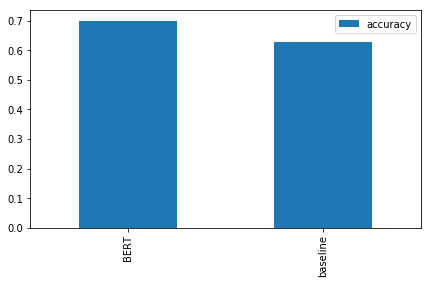

In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({"accuracy": {"baseline": baseline_accuracy, "BERT": bert_accuracy}})
plt.rcParams['figure.figsize'] = (7,4)
df.plot(kind="bar")

BERT obtains an accuracy of around 70% on the test data. This is around 8% more than our initial baseline classifier. This confirms that BERT's transfer learning helps us achieve significantly higher accuracies for small datasets. Ofcourse the results can be even better if we train BERT for more time, but I had to stop here because of GPU constraints.